# Predicting Face attractiveness
This notebook follows on [this other notebook](https://github.com/Pantalaymon/facial-attractiveness-ratings/blob/main/Facial_ratings_analysis.ipynb) on analysing facial ratings. The previous notebook aimed to analyse how people rate a face ; we examined 
- the distribution of averages ratings across multiple pictures
- how several variables (gender and ethnicity) correlate with the ratings
- how individual raters rate different faces
- how different people rate a same face


In the present notebook, our goal is to predict the attractiveness of faces using the MEBeauty dataset. We will explore the dataset, perform feature engineering, select appropriate models, and evaluate their performance. Ultimately, we aim to build a predictive model that can accurately estimate the attractiveness of faces based on various features.

## Objectives

The primary objectives of this notebook are:

1. **Leveraging Pretrained Models**: Utilize a pretrained CNN to predict attractiveness scores, taking advantage of transfer learning to improve model performance.
2. **Model Selection and Training**: Fine-tune the pretrained CNN for our specific task and evaluate its performance.
3. **Explainability**: Ensure the model is interpretable so that we can understand which features it considers important for predicting attractiveness. This will lay the groundwork for identifying characteristic features of attractiveness in [the next notebook](https://github.com/Pantalaymon/facial-attractiveness-ratings/blob/main/Facial_features_identification.ipynb).
4. **Model evaluation**: Evaluate the model on unseen data and discuss the results, especially with regards to human ratings.



By the end of this notebook, we aim to have a robust, explainable model that can predict the attractiveness of faces based on a diverse set of features. This model will provide insights into the factors that influence perceived attractiveness and demonstrate the potential of using deep learning for analyzing human perceptions.

## Preparing Data

In [1]:
%%writefile utils.py

import os
from pathlib import Path
from PIL import Image
import random

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torchvision import models, transforms
import matplotlib.pyplot as plt




Overwriting utils.py


In [2]:

import os
import requests
from tqdm import tqdm
from pathlib import Path
from PIL import Image
import random
import inspect
import joblib

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import models, transforms
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split


### Ratings

In [3]:

link_data = "https://github.com/fbplab/MEBeauty-database/raw/main/scores/generic_scores_all_2022.xlsx"
df = pd.read_excel(link_data)
df = df.iloc[:, 0:3] #remove individual ratings
df.rename(columns={"mean":"rating"}, inplace=True)
df = df.round(decimals=1) #will make computations easier and lmore reliable


In [4]:
# Save the functions we want to reuse to a file
def save_functions_to_file(filename, *funcs):
    with open(filename, 'a') as f:
        for func in funcs:
            func_code = inspect.getsource(func)
            f.write(func_code + '\n')

def standardize_path(cell):
    # We only want the architecture of the path from {gender}.
    # That way later we can provide whatever root path we want for the dataset
    path = Path(cell)
    return "/".join(path.parts[-3:])

def extract_gender_ethnicity(row):
    try :
        path = Path(row["path"])
        gender, ethnicity = path.parts[-3: -1]
    except TypeError:
        gender, ethnicity = None, None
    return gender, ethnicity



save_functions_to_file('utils.py', standardize_path, extract_gender_ethnicity)

In [5]:

df[['gender', 'ethnicity']] = df.apply(extract_gender_ethnicity, axis=1, result_type="expand")


# Drop  missing values if any
df.dropna(inplace=True)
df.drop("image", axis=1, inplace=True)


df["path"] = df["path"].apply(standardize_path)

In [6]:
df

,rating,path,gender,ethnicity
0,1.1,female/caucasian/kuma-kum-GKbPbR0ZAT4-unsplash...,female,caucasian
1,1.0,male/asian/pexels-cottonbro-5529905.jpg,male,asian
2,1.0,male/indian/pexels-nishant-aneja-2561432.jpg,male,indian
4,1.5,female/indian/pexels-himesh-mehta-3059930.jpg,female,indian
5,1.9,male/asian/pexels-kaniseeyapose-2751061.jpg,male,asian
...,...,...,...,...
2602,9.0,female/caucasian/pexels-pixabay-247322.jpg,female,caucasian
2603,9.4,female/asian/women-5930352_1920.jpg,female,asian
2604,9.2,female/hispanic/francesca-zama-1fhl_kmbfAE-uns...,female,hispanic
2605,9.6,female/caucasian/sofia--LNdco1UgNY-unsplash.jpg,female,caucasian


We saw in our previous analysis that there is noticeable correlation between the covariable gender and ethnicities and the rating. Although this is true for human judgement , we do not want our model to reproduce this human bias : we want each subset of gender and ethnicity to be rated without consideration for this group (as far as possible). To eliminate bias due to gender and ethnicity in our dataset and ensure a suitable range for training, we implement a two-step normalization process. First, we perform standardization on each subset of the data (defined by gender and ethnicity). This standardization ensures that all subsets had a mean of 0 and a standard deviation of 1, aligning their distributions and mitigating bias inherent to each subset.

Next, we rescale the standardized values across the entire dataset to the range 0-10. This rescaling maintains consistency and allows the standardized ratings to fully utilize the desired scale. Note that to facilitate training and accelerate convergence, we  will keep the dataset as it was before rescaling (and after regularization) for training, but we set aside the scaler and its rescaling parameters so that we can reuse it later when we need to convert the rating (like one given by the model) to a human-friendly scale.

In [7]:

def standardize(subset):
    
    
    # Calculate mean and standard deviation for each subset
    subset_mean = subset['rating'].mean()
    subset_std = subset['rating'].std()
    
    # Standardize ratings to mean 0 and std 1 (z-scores)
    subset['standardized_rating'] = (subset['rating'] - subset_mean)  / subset_std
    
    return subset


# Apply the function to each subset
df_standardized = df.groupby([ 'ethnicity']).apply(standardize).reset_index(drop=True)

scaler = MinMaxScaler(feature_range=(0, 10))
df_standardized['rescaled_rating'] = scaler.fit_transform(df_standardized[['standardized_rating']].to_numpy())


joblib.dump(scaler, 'models/min_max_scaler.pkl')
scaler = joblib.load('models/min_max_scaler.pkl')


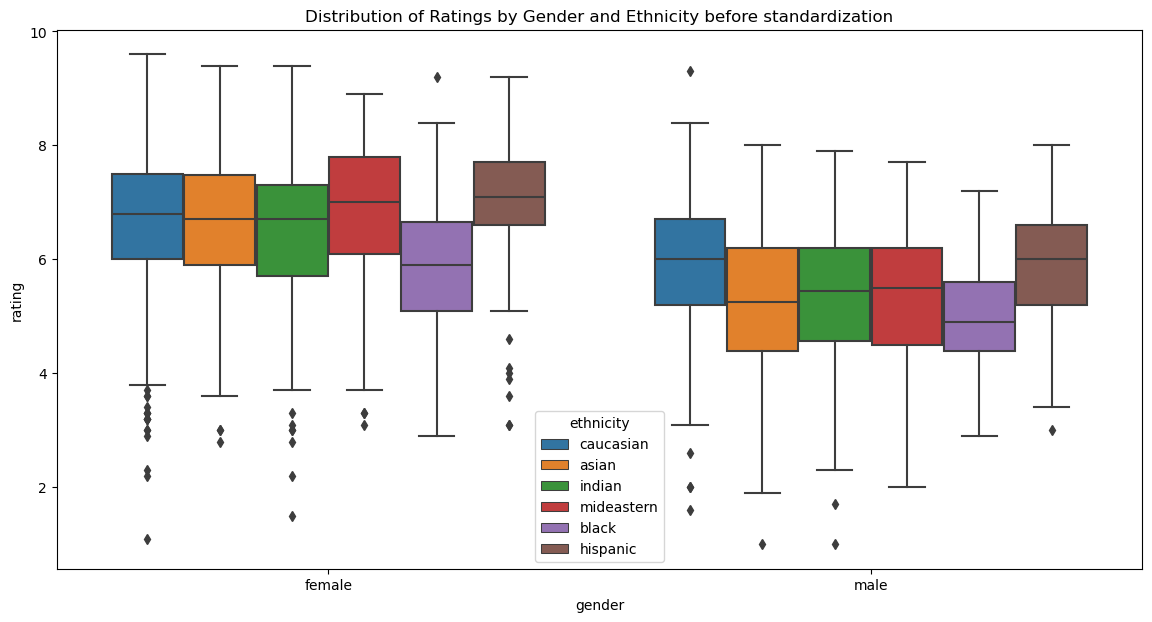

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 7))
sns.boxplot(x='gender', y='rating', hue='ethnicity', data=df)
plt.title('Distribution of Ratings by Gender and Ethnicity before standardization')
plt.show()

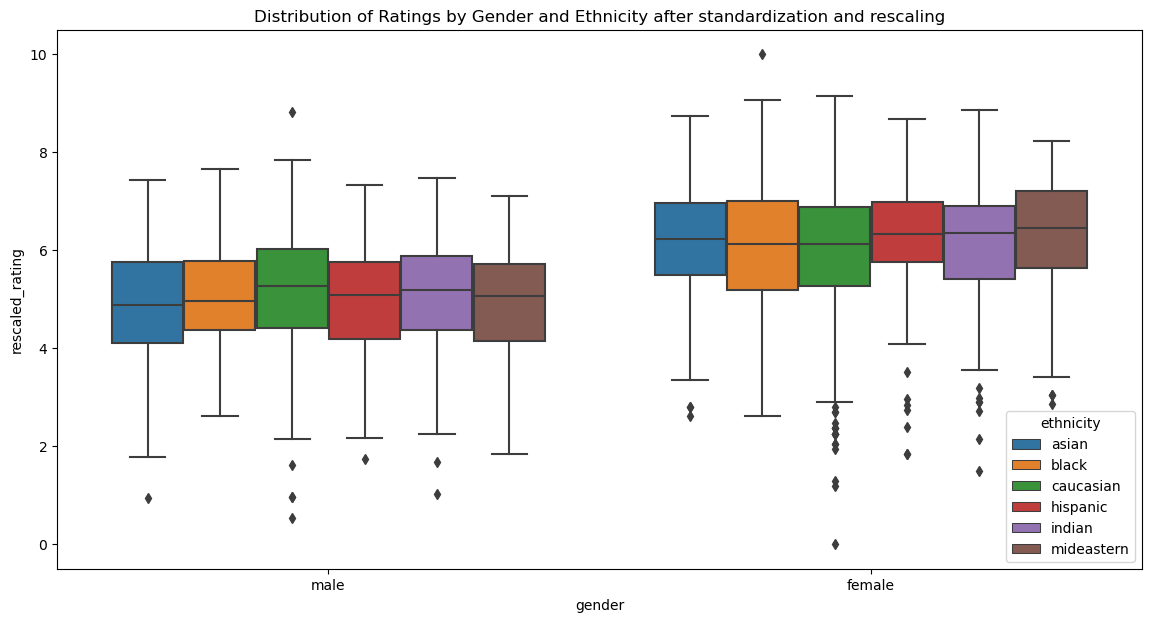

In [9]:

plt.figure(figsize=(14, 7))
sns.boxplot(x='gender', y='rescaled_rating', hue='ethnicity', data=df_standardized)
plt.title('Distribution of Ratings by Gender and Ethnicity after standardization and rescaling')
plt.show()


In [10]:

#df = df_standardized.drop(columns=[ "standardized_rating"  ])
df = df_standardized.rename(columns={"rescaled_rating":"rating","rating": "original_rating"}) # we will use the standardized rating before rescaling for training
df.rating.mean() , df.rating.std()

(5.590979528116394, 1.3093031133442359)

Awesome! Now we have unified mean and standard deviation for each ethnicity. The only downside is that now our mean is slightly lower (5.6 VS 6.2 before). We are gonna be slightly stricter than humans. Our ratings are going to be about as scattered around the mean as humans (1.31)

Note that we have decided to only adjust for the bias regarding ethnicity and not for gender after analysing the dataset. Indeed through experimentation we found that adjusting for gender would result in ratings that deviate too much from human ratings (especially for women) to be satisfying.  This leaves another issue : rating inbalance across genders. This will be adressed below in the section #Data Augmentation

### Images
After removing the missing values, we have 2553 images. That's a lot of pictures ! Let's download them locally so that we can load them more easily later. You may take a cup of tea, this may take a while. Note that you may also only download the cropped dataset which is faster and takes less space on the machine.

In [11]:


# Function to download a file from a URL
def download_file(url, save_path):
    response = requests.get(url, stream=True)
    with open(save_path, 'wb') as file:
        for data in response.iter_content(chunk_size=1024):
            file.write(data)


def download_dataset(df, dataset_url, output_dir, rewrite=False):
    
    image_paths = df['path'].tolist()
    with tqdm(total=len(image_paths), unit='file') as pbar:
        for  path in image_paths:
            local_path = os.path.join(output_dir, path)
            if  rewrite or not os.path.isfile(local_path):
                write_dir = os.path.join(output_dir, *Path(path).parts[:-1])
                #print(write_dir)
                os.makedirs(write_dir, exist_ok=True)
                download_file(os.path.join(dataset_url , path), local_path)
            pbar.update(1)



In [12]:

# URLs of the images
base_url_original = 'https://github.com/fbplab/MEBeauty-database/raw/main/original_images/'
base_url_cropped = 'https://github.com/fbplab/MEBeauty-database/raw/main/cropped_images/images_crop_align_opencv/'

download_dataset(df, base_url_original, 'images/original', rewrite=False)

100%|██████████████████████████████████████████████████████████████████████████| 2553/2553 [00:00<00:00, 5256.28file/s]


In [13]:
download_dataset(df, base_url_cropped, 'images/cropped', rewrite=False)

100%|██████████████████████████████████████████████████████████████████████████| 2553/2553 [00:00<00:00, 6675.45file/s]


Some of the images may be corrupted. Let's get rid of them before they cause us any problem downstream. It's ok, we have lots of them.

In [14]:


def is_image_loadable(image_path):
    try:
        img = Image.open(image_path)
        img.verify()  # Verify that it is, indeed an image
        return True
    except (IOError, SyntaxError) as e:
        print(f'Bad file: {image_path}')
        return False

def filter_corrupted_images(df, images_dir):
    df['full_path'] = df['path'].apply(lambda p: os.path.join(images_dir, p))
    df['is_valid'] = df['full_path'].apply(is_image_loadable)
    df_cleaned = df[df['is_valid']].drop(columns=['full_path', 'is_valid']).reset_index(drop=True)
    return df_cleaned



save_functions_to_file('utils.py', is_image_loadable, filter_corrupted_images)


In [15]:

# Assuming your dataframe is named 'df' and the base path to your images is 'images_dir'
image_dir = 'images/original'
df_cleaned = filter_corrupted_images(df, image_dir )

# Check the number of images that were successfully loaded
print(f'Number of valid images: {len(df_cleaned)}')
print(f'Number of corrupted images removed: {len(df) - len(df_cleaned)}')

df = df_cleaned

Bad file: images/original\male/asian/tanjir-ahmed-chowdhury-YMJvX8k3Kfc-unsplash.jpg
Bad file: images/original\female/asian/pexels-rodnae-productions-4911184.jpg
Bad file: images/original\female/asian/pexels-kevin-kabore-4966995.jpg
Bad file: images/original\male/black/payton-tuttle-n_RdRxH_7h4-unsplash.jpg
Bad file: images/original\male/black/doil-oh-v15GcVql4CM-unsplash.jpg
Bad file: images/original\female/black/woman-984426_1920.jpg
Bad file: images/original\female/caucasian/brunette-2478405_1920.jpg
Bad file: images/original\male/caucasian/boy-1105361_1920.jpg
Bad file: images/original\male/caucasian/business-man-1385050_1920.jpg
Bad file: images/original\female/caucasian/creating-a-brand-WxAOdbDpMiU-unsplash.jpg
Bad file: images/original\male/caucasian/man-1488305_1920.jpg
Bad file: images/original\male/caucasian/model-4493512_1920.jpg
Bad file: images/original\male/caucasian/montgomery-clift-402456_1920.jpg
Bad file: images/original\male/caucasian/g_7.jpg
Bad file: images/origina

In [16]:

def load_images(df, image_dir, num_images=5, gender=None, ethnicity=None):
    '''
     loads a set number of random images within the directory 
    '''
    # Extract gender and ethnicity from the path and add them as columns to the DataFrame
    gender_col = df['path'].apply(lambda x: x.split('/')[0])
    ethnicity_col = df['path'].apply(lambda x: x.split('/')[1])
    
    # Apply gender filter if specified
    if gender is not None:
        df = df[gender_col == gender]
    
    # Apply ethnicity filter if specified
    if ethnicity is not None:
        df = df[ethnicity_col.isin(ethnicity)]

    selected_df = df.sample(n=num_images)
    
    images = []
    real_scores = []
    
    for idx, row in selected_df.iterrows():
        img_path = os.path.join(image_dir, row['path'])

        image = Image.open(img_path).convert('RGB')
        images.append(image)
        real_scores.append(row['rating'])
    
    # Drop the temporary columns
    #df.drop(columns=['gender', 'ethnicity'], inplace=True)

    
    return selected_df.index, images, real_scores

def display_images(images, real_scores, predicted_scores=None):
    max_per_row = 5
    num_images = len(images)
    num_rows = (num_images + max_per_row - 1) // max_per_row  # Calculate number of rows needed
    
    plt.figure(figsize=(15, 3 * num_rows))  # Adjust height based on the number of rows
    
    if predicted_scores is None:
        predicted_scores = [None] * len(real_scores)
    
    for i, (image, predicted_score, real_score) in enumerate(zip(images, predicted_scores, real_scores)):
        ax = plt.subplot(num_rows, max_per_row, i + 1)
        ax.imshow(image)
        
        if predicted_score is None:
            ax.set_xlabel(f'Rating: {real_score:.2f}', fontsize=12)
        else:
            ax.set_title(f'Predicted: {predicted_score:.2f}', fontsize=12)
            ax.set_xlabel(f'Real: {real_score:.2f}', fontsize=12)
        
        ax.set_xticks([])  # Hide x ticks
        ax.set_yticks([])  # Hide y ticks
        for spine in ax.spines.values():
            spine.set_visible(False)  # Hide the spines
    
    plt.tight_layout()
    plt.show()



save_functions_to_file('utils.py', load_images, display_images)

In [17]:
df

,original_rating,path,gender,ethnicity,rating,rescaled_rating
0,1.0,male/asian/pexels-cottonbro-5529905.jpg,male,asian,-3.549892,0.938535
1,1.9,male/asian/pexels-kaniseeyapose-2751061.jpg,male,asian,-2.911921,1.774652
2,2.4,male/asian/raphiell-alfaridzy-jagYILIMvxw-unsp...,male,asian,-2.557492,2.239162
3,2.0,male/asian/pexels-chevanon-photography-2421934...,male,asian,-2.841035,1.867554
4,2.9,male/asian/chander-mohan-9zaQ3PjrvxA-unsplash.jpg,male,asian,-2.203064,2.703672
...,...,...,...,...,...,...
2518,8.2,female/mideastern/sour-moha-Uxo2j3rJq5Y-unspla...,female,mideastern,1.513332,7.574333
2519,8.3,female/mideastern/pexels-artem-podrez-5125221.jpg,female,mideastern,1.583968,7.666908
2520,8.5,female/mideastern/kirill-balobanov-Ef3AOkt6hHg...,female,mideastern,1.725241,7.852059
2521,8.7,female/mideastern/53.jpg,female,mideastern,1.866514,8.037209


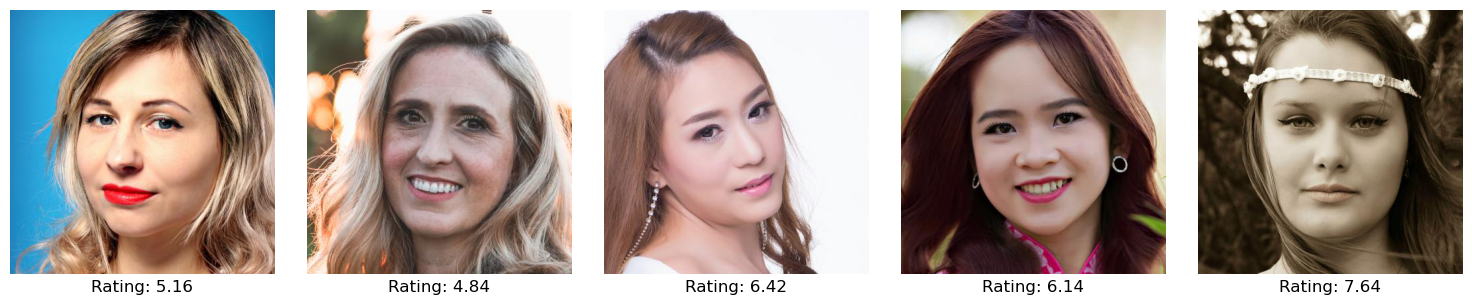

In [18]:

# Load a few  images of women
image_dir = 'images/original'
idxs, images, ratings = load_images(df, image_dir, num_images=5, gender="female")
rescaled_ratings = scaler.transform(np.array(ratings).reshape(-1, 1)).reshape(-1)

display_images(images, rescaled_ratings)


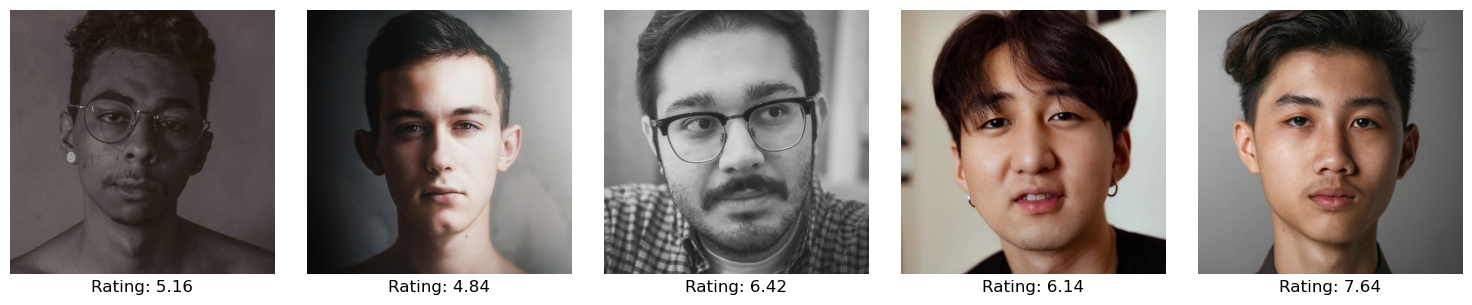

In [19]:
idxs, images, ratings = load_images(df, image_dir, num_images=5, gender="male")

ratings = scaler.transform(np.array(ratings).reshape(-1, 1)).reshape(-1)
display_images(images, rescaled_ratings)

In [20]:
df.columns

Index(['original_rating', 'path', 'gender', 'ethnicity', 'rating',
       'rescaled_rating'],
      dtype='object')

## Data Augmentation

Analysing the dataset, we found that there is a clear rating inbalance across genders. Not only women are rated higher on average, but there is a clear lack of men with high ratings in the dataset. As a matter of fact, there are only 4 men with a rating above 8 in the entire dataset (while there 117 for women) ! 

In [21]:
df[df.original_rating > 8].groupby("gender").original_rating.count(), df[df.original_rating > 7].groupby("gender").original_rating.count()

(gender
 female    117
 male        4
 Name: original_rating, dtype: int64,
 gender
 female    528
 male       93
 Name: original_rating, dtype: int64)

This will be problematic if we want our model to be able to rate men who are considered very attractive. To mitigate this issue, we will perform  targeted data augmentation for attractive men. This should enhance the diversity and representativeness of your dataset, leading to improved model performance and fairness in predictions across genders.

In [22]:

# Define the number of synthetic samples to generate for each image depending on the rating : above 7 or above 8
num_synthetic_samples_for_7 = 2
num_synthetic_samples_for_8 = 4
augmented_dir = "images/original/augmented_images"
os.makedirs(augmented_dir, exist_ok=True)

# Create a list of augmentation transformations
transformations = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.3),
    transforms.RandomApply([transforms.RandomAffine(degrees=0, translate=(0.1, 0.1))], p=0.3),
    transforms.RandomApply([transforms.RandomAffine(degrees=0, scale=(0.9, 1.1))], p=0.3),
    transforms.RandomApply([transforms.RandomAffine(degrees=0, shear=15)], p=0.3)
])

selected_df = df[(df['original_rating'] > 7) & (df['gender'] == "male")]

augmented_rows = []
# Iterate over the dataframe rows
for index, row in selected_df.iterrows():
    # Open the original image
    image_path = row['path']
    original_image = Image.open(os.path.join(image_dir, image_path))
    n_new_samples = num_synthetic_samples_for_7 if row["original_rating"] < 8 else num_synthetic_samples_for_8

    # Apply augmentation and save synthetic samples
    for i in range(n_new_samples):
        augmented_image = transformations(original_image)
        augmented_filename = os.path.basename(image_path).split('.')[0] + f'_augmented_{i}.jpg'
        augmented_image_path = os.path.join(augmented_dir,  augmented_filename)
        augmented_image.save(augmented_image_path)

        # Update the dataframe with the path to the augmented image and inherited ratings
        augmented_row = {
            'original_rating': row['original_rating'],  # Inherited from the original image
            'path': os.path.join("augmented_images", augmented_filename),
            'gender': row['gender'],  # Inherited from the original image
            'ethnicity': row['ethnicity'],  # Inherited from the original image
            'rating': row['rating'],  # Inherited from the original image
            'standardized_rating': row['standardized_rating']  # Inherited from the original image
        }
        # Append the augmented row to the list
        augmented_rows.append(augmented_row)

# Convert the list of augmented rows to a DataFrame
augmented_df = pd.DataFrame(augmented_rows)

In [23]:
augmented_df

,original_rating,path,gender,ethnicity,rating,rescaled_rating
0,7.8,augmented_images\pexels-ba-phi-1339536_augment...,male,asian,1.270336,7.255866
1,7.8,augmented_images\pexels-ba-phi-1339536_augment...,male,asian,1.270336,7.255866
2,7.2,augmented_images\model-2911332_1920_augmented_...,male,asian,0.845022,6.698455
3,7.2,augmented_images\model-2911332_1920_augmented_...,male,asian,0.845022,6.698455
4,7.3,augmented_images\pexels-raul-reynoso-1578531_a...,male,asian,0.915907,6.791356
...,...,...,...,...,...,...
195,7.7,augmented_images\milad-shams-89UvLA2zWJI-unspl...,male,mideastern,1.160150,7.111457
196,7.7,augmented_images\mehrdad-dadaei--aY-mUygMD0-un...,male,mideastern,1.160150,7.111457
197,7.7,augmented_images\mehrdad-dadaei--aY-mUygMD0-un...,male,mideastern,1.160150,7.111457
198,7.2,augmented_images\hannah-cook-dqa2LjshmWY-unspl...,male,mideastern,0.806968,6.648581


In [24]:
#df = pd.concat([df, augmented_df], ignore_index=True)
df.groupby("gender").count()

,original_rating,path,ethnicity,rating,rescaled_rating
gender,,,,,
female,1340,1340,1340,1340,1340
male,1183,1183,1183,1183,1183


## Loading Data
First we will split the dataset into : 
- training set (72%)  examples to train the model
- validation set (18%) to see how the model perform during training
- test set (10%), left untouched until we are content with our model. For final evaluation

In [25]:
image_dir = 'images/original/'
# Split the dataset into train/validation and test sets
train_val_df, test_df = train_test_split(df, test_size=0.1, random_state=42)

# Further split the train_val_df into training and validation sets
train_df, val_df = train_test_split(train_val_df, test_size=0.2, random_state=42)

Since our dataset is made of images, and is quite large, it would be tedious to keep it in memory. Let's set up a dataloader to use it during training and swiftly access the images.

In [26]:
class AttractivenessDataset(Dataset):
    def __init__(self, dataframe, dataset_dir=".", transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.dataset_dir = dataset_dir

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = os.path.join(self.dataset_dir, self.dataframe.iloc[idx]['path'])
        image = Image.open(img_path).convert("RGB")
        label = self.dataframe.iloc[idx]['rating']
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.float32)


In [27]:


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create Datasets
train_dataset = AttractivenessDataset(train_df, image_dir, transform=transform)
val_dataset = AttractivenessDataset(val_df,  image_dir, transform=transform)
test_dataset = AttractivenessDataset(test_df,  image_dir, transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)




## Training the model 
Since the goal of this notebook is note to train a neural network from scratch but simply to , we are going to use a pre-trained CNN neural Network. Leveraging the knowledge gained by a pre-trained model on large image datasets, we hope to  easily capture the features of the faces in our dataset so as to find patterns with respect to the attractiveness scores. After several tests our final choice landed on MobileNetV2 : a lightweight pretrained Convolutional Neural Network (CNN) model for the following reasons :

- Size and Speed: This model is designed to be small and fast, making itsuitable for training on personal machines.
- Performance: Despite its size, it offers good performance for various computer vision tasks. It is reliable as it has been extensively by the community.
- Explainability: The model works well with explainability techniques suwhich can help us visualize the features that the model uses to make predictions. This will come into play in a later notebook.


MobileNetV2  was originally trained on a classification task, on the ImageNet dataset, which contains millions of images across a thousand different classes.T he architecture consists of an initial convolution layer, followed by a series of bottleneck layers that utilize depthwise separable convolutions and linear bottlenecks. These layers are designed to capture intricate patterns and features in images, we hope to leverage that knowledge in our regression task.
Our task is a pretty straight-forward regression task where we try to predict scores between 1 and 10. Thus the choice of the Mean squared error as the loss function. We simply replace the classification layer (1000 classes so 1000 output neurons) of the original network with a new fully connected layer that outputs a single continuous value representing the attractiveness score.

In [28]:

# Load the MobileNetV2 model
def load_model(device):
    model = models.mobilenet_v2(pretrained=True)
    
    # Modify the classifier for regression with sigmoid activation
    model.classifier[1] = nn.Sequential(
        nn.Linear(model.classifier[1].in_features, 1)
    )
    
    # Move the model to the GPU if available
    model = model.to(device)
    return model


def load_checkpoint(model, optimizer, path='models/best_model.pth'):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    best_val_loss = checkpoint['best_val_loss']
    return model, optimizer, start_epoch, best_val_loss


save_functions_to_file('utils.py', load_model, load_checkpoint)

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = load_model(device)

D:\Utilisateurs\souma\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\Utilisateurs\souma\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [30]:


def save_checkpoint(model, optimizer, epoch, best_val_loss, path='models/best_model.pth'):
    os.makedirs(Path(path).parent, exist_ok=True)
    state = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'best_val_loss': best_val_loss
    }
    torch.save(state, path)
    print(f"Checkpoint saved at epoch {epoch+1} with validation loss: {best_val_loss:.4f}")


def train_model(
    model, train_loader, val_loader, loss_func, optimizer, 
    num_epochs=20, start_epoch=0, best_val_loss =float('inf'), device='cuda',
    save_path = 'models/best_model.pth'
):
    train_losses = []
    val_losses = []
    
    for epoch in range(start_epoch, num_epochs):
        model.train()
        train_loss = 0.0
        # gradient descent algo
        for images, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_func(outputs.squeeze(), labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * images.size(0)

        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = loss_func(outputs.squeeze(), labels)
                val_loss += loss.item() * images.size(0)

        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            save_checkpoint(model, optimizer, epoch, best_val_loss, path=save_path)
    return train_losses, val_losses




In [ ]:

#hyperparameters 
start_epoch = 0
best_val_loss = float('inf')
num_epochs = 20
lr = 1e-4

# Define the loss function for regression task and optimizer
loss_func = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# If the model has already been trained before or the training has been stopped before completion we can simply reload it before resuming training
'''

checkpoint_path = 'models/best_model.pth'
model, optimizer, start_epoch, best_val_loss = load_checkpoint(model, optimizer, path=checkpoint_path)

'''


# Train the model
train_losses, val_losses = train_model(
    model, train_loader, val_loader, loss_func, optimizer, num_epochs=num_epochs, 
    start_epoch=start_epoch, best_val_loss=best_val_loss, device=device
)

Epoch 1/20: 100%|██████████████████████████████████████████████████████████████████████| 57/57 [05:04<00:00,  5.34s/it]


Epoch 1/20, Train Loss: 0.6931, Val Loss: 0.5967
Checkpoint saved at epoch 1 with validation loss: 0.5967


Epoch 2/20: 100%|██████████████████████████████████████████████████████████████████████| 57/57 [04:50<00:00,  5.09s/it]


Epoch 2/20, Train Loss: 0.3973, Val Loss: 0.5767
Checkpoint saved at epoch 2 with validation loss: 0.5767


Epoch 3/20: 100%|███████████████████████████████████████████████████████████████████| 57/57 [4:48:15<00:00, 303.44s/it]


Epoch 3/20, Train Loss: 0.2512, Val Loss: 0.5957


Epoch 4/20:  21%|██████████████▋                                                       | 12/57 [00:48<03:02,  4.06s/it]

Let's see how the training went. Since this is a regression task, we don't need any accuracy metrics. Our final objective is the same as the optimization goal given to the model (or rather its inverse) that is : minimizing the Mean square error, or in other words : we want our predicted scores to be the closest possible to the real scores. We will plot the Mean Squared Error for the training set and for the validation set.

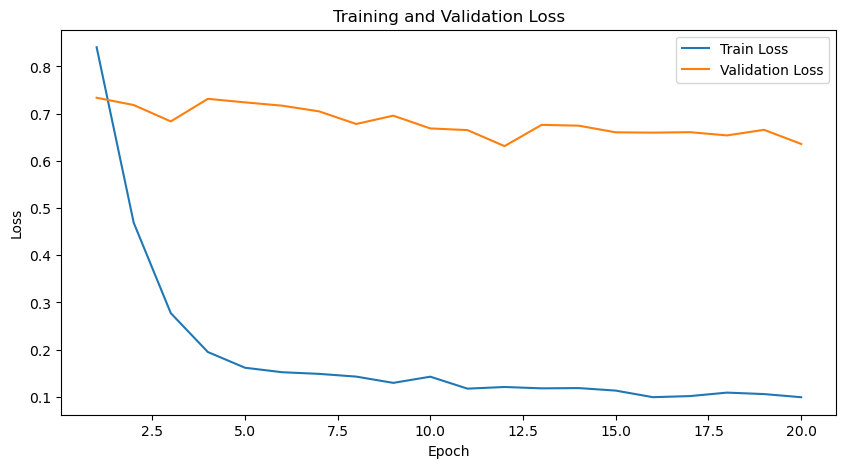

In [139]:
# Plot the performance evolution
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

 We stopped training at 20 epochs because the reduction of the loss for each epoch was really small but it seems that it had not converged et and both train loss and validation loss kept going down, ever so slightly. If you have the time and resources on your machine, you may want to let it train longer. 

We can also train a model on the original data in the hope to make a model that is more faithful to human ratings, despite their biases.

In [ ]:
'''
# Create Datasets
train_df = train_df.rename(columns={"rating":"rescaled", "original_rating":"rating"}
val_df = val_df.rename(columns={"rating":"rescaled", "original_rating":"rating"}
test_df = test_df.rename(columns={"rating":"rescaled", "original_rating":"rating"}

train_dataset = AttractivenessDataset(train_df, image_dir, transform=transform)
val_dataset = AttractivenessDataset(val_df,  image_dir, transform=transform)
test_dataset = AttractivenessDataset(test_df,  image_dir, transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_og_data = load_model(device)


#hyperparameters 
start_epoch = 0
best_val_loss = float('inf')
num_epochs = 20
lr = 1e-4

# Define the loss function for regression task and optimizer
loss_func = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)




# Train the model
train_losses, val_losses = train_model(
    model_og_data, train_loader, val_loader, loss_func, optimizer, num_epochs=num_epochs, 
    start_epoch=start_epoch, best_val_loss=best_val_loss, device=device, save_path='models/best_model_nonstandardized.pth'
)
'''

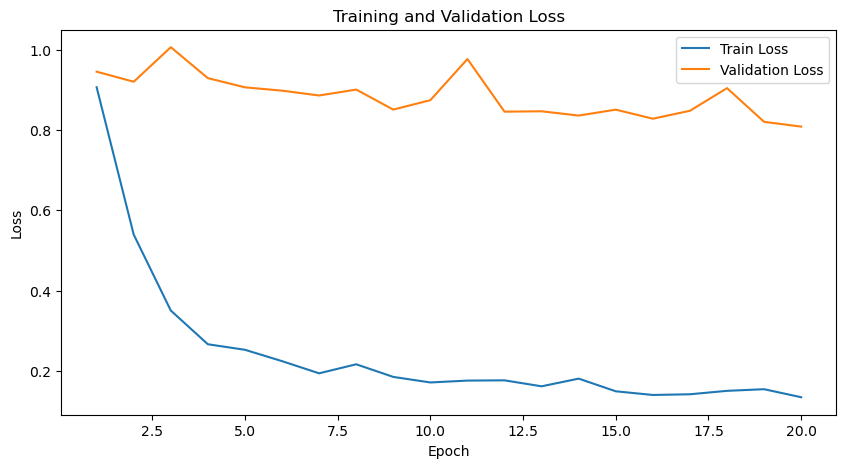

In [20]:
"""
# Plot the performance evolution
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()
"""

## Inference

In [140]:


def predict_attractiveness(model, images, device='cuda'):
    model.eval()
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
    images_tensor = torch.stack([transform(image) for image in images]).to(device)
    
    with torch.no_grad():
        outputs = model(images_tensor)
        scores = outputs.squeeze().cpu().numpy()
    
    return scores





save_functions_to_file('utils.py', predict_attractiveness)
    

In [141]:

lr = 1e-4
loss_func = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
checkpoint_path = 'models/best_model.pth'
model, optimizer, start_epoch, best_val_loss = load_checkpoint(model, optimizer, path=checkpoint_path)

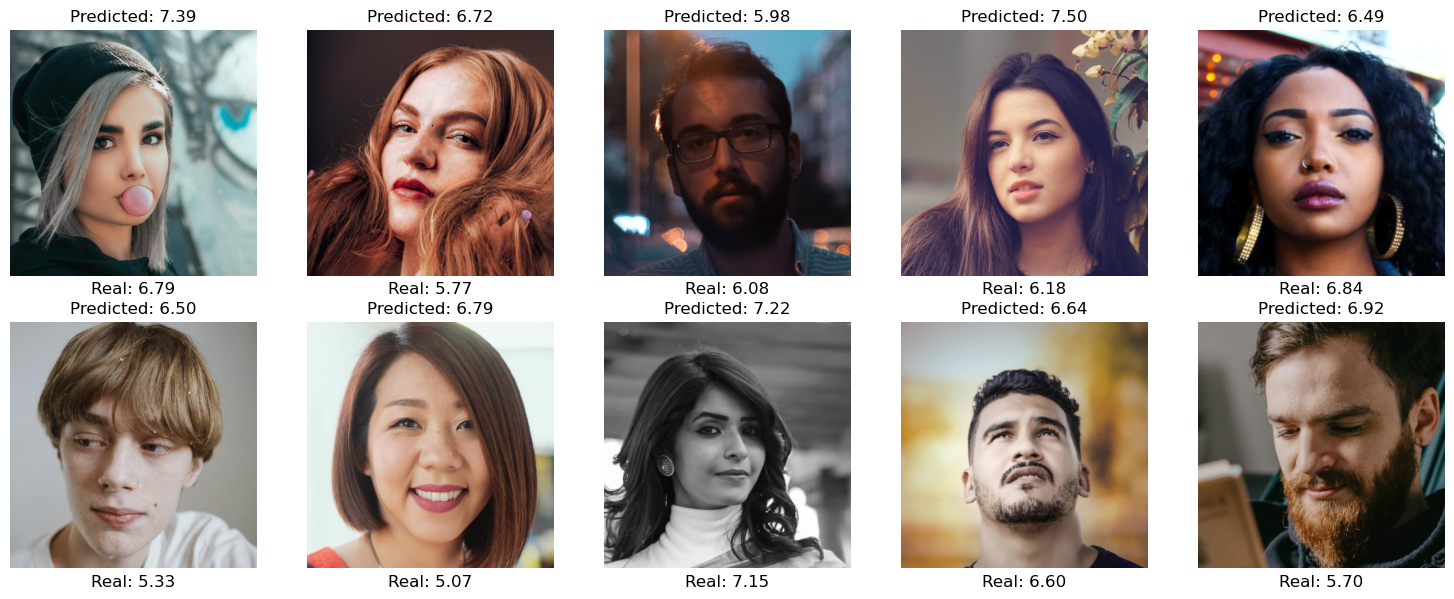

In [145]:


# Load random images from the directory and get their real scores
images, real_scores = load_images(df, image_dir, num_images=10)

real_scores = scaler.transform(np.array(real_scores).reshape(-1, 1)).reshape(-1)

# Predict attractiveness scores
predicted_scores = predict_attractiveness(model, images, device=device)

predicted_scores = scaler.transform(np.array(predicted_scores).reshape(-1, 1)).reshape(-1)

# Display images with their predicted and real scores
display_images(images,  real_scores, predicted_scores)

## Evaluation
Based on our observation the model seems to rate pretty accurately. It has a slight tendency to refrain from giving very high ratings (above 8) even for faces that have a very high ground-tooth rating.
At last, once we are content with are model, let's see our it performs on unseen data. We are going two use two metrics :

### MSE
- Mean Squared Error (MSE): MSE penalizes larger errors more than smaller ones, making it useful for highlighting models that have some large prediction errors. As a matter of fact, since rating faces is ultimatly subjective, there is no such thing as a precise, objective, accurate rating of a face. However, [as we already found out in our previous notebook](https://github.com/Pantalaymon/facial-attractiveness-ratings/blob/main/Facial_ratings_analysis.ipynb#Inter-rater-variation-in-rating), there is a relative consensus in how faces are rated : the ratings for one face have a standard deviation of 1.8 on average. Ultimately what we aim to do is to reproduce the aesthetic judgement of humans and not to go too far from the mean of ratings. That's why MSE is a good choice since it penalises large deviation from the real mean score

Besides, minimising MSE on the training set was the optimisation goal set during training. It was also the metric used to evaluate performance on the validation set for model selection. Comparing MSE on the training set, validation set and test set will kept us evaluate overfitting.

### MAE 
- The Mean Absolute Error (MAE): MAE gives a straightforward measure of prediction accuracy by showing the average error in the same units as the target variable. It will allow us to see exactly how far away from the target score our predictions are on average


In [147]:

from sklearn.metrics import mean_absolute_error, mean_squared_error

def evaluate_model(model, test_loader, device='cuda'):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(outputs.cpu().numpy().squeeze())
    
    all_labels = scaler.transform(np.array(all_labels).reshape(-1, 1)).reshape(-1)
    all_preds = scaler.transform(np.array(all_preds).reshape(-1, 1)).reshape(-1)

    # Calculate metrics
    mae = mean_absolute_error(all_labels, all_preds)
    mse = mean_squared_error(all_labels, all_preds)
    print(f'MAE: {mae:.4f}')
    print(f'MSE: {mse:.4f}')

    return mae, mse

# Assuming the test DataLoader and criterion are already defined
mae, mse = evaluate_model(model, test_loader,  device=device)

MAE: 0.7809
MSE: 0.9868


The MAE and MSE are both under 0.8 which is really good for a total scale of 9 points (btween 1 and 10). The MSE is above the best train loss (0.13) but slighly below the best validation loss (0.8) which means that we managed to avoid overfitting and the model generalises very well.

### Conclusion 

Let's analyse two facts : 
- Standard Deviation of human ratings
The standard deviation of 1.88 in human ratings suggests that there is relative disagreement among raters about the attractiveness scores. This means that if we pick a random rating from a human rater, it could be, on average, 1.88 points away from the mean rating given by the crowd.

- Model's MAE
An MAE of 0.7 means that the model's predictions are, on average, 0.7 points away from the mean rating. This is substantially lower than the 1.88-point standard deviation of individual human ratings.


Given that the model's average error is significantly less than the average variability in human ratings, we can make the following observations:

- Closer to Mean Rating: The model's predictions are, on average, closer to the mean rating than a random human rating would be. This implies that the model has learned to predict an attractiveness score that is more aligned with the consensus of multiple raters rather than the opinion of a single individual.

- Consistency: The lower MAE indicates that the model is more consistent in its predictions compared to the variability among individual raters.


We can conclude that the model gives a prediction closer to the average human rating than a random human rater does. The significant difference between the model's MAE (0.7) and the standard deviation of human ratings (1.88) suggests that the model is quite effective at approximating the collective judgment of multiple raters.
